# Detecção de Anomalias em Hemograma - Isolation Forest

**Objetivo:** Identificar exames de hemograma com padrões anômalos que possam indicar casos críticos ou atípicos.

## O que vamos fazer:

1. Detectar anomalias usando **Isolation Forest**
2. Detectar anomalias usando **Z-score Multivariado**
3. Comparar os dois métodos
4. Visualizar e caracterizar os casos anômalos
5. Interpretação clínica dos resultados

## Por que isso é útil?

**Para Médicos:**
- Identificar rapidamente exames que fujam do padrão
- Priorizar casos potencialmente críticos
- Detectar padrões incomuns que merecem atenção

**Para Laboratórios:**
- Controle de qualidade automatizado
- Detecção de erros de medição
- Triagem de amostras prioritárias

## 1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Importar classes do nosso projeto
import sys
sys.path.append('../src')
from models import DetectorAnomalias

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregar Dados Limpos

In [ ]:
# Carregar dataset LIMPO
df = pd.read_csv('../data/processed/cbc_limpo.csv')

print(f" Dataset carregado: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())

df.head()

✓ Dataset carregado: 424 linhas × 21 colunas

Colunas disponíveis:
['ID', 'WBC', 'LYMp', 'MIDp', 'NEUTp', 'LYMn', 'MIDn', 'NEUTn', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDWSD', 'RDWCV', 'PLT', 'MPV', 'PDW', 'PCT', 'PLCR']


,ID,WBC,LYMp,MIDp,NEUTp,LYMn,MIDn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,RDWSD,RDWCV,PLT,MPV,PDW,PCT,PLCR
0,1,10000.0,43.2,6.7,50.1,4.3,0.7,5.0,2.77,7.3,24.2,87.7,26.3,30.1,35.3,11.4,189000.0,9.2,12.5,0.17,22.3
1,3,7200.0,30.7,8.6,60.7,2.2,0.6,4.4,3.97,9.0,30.5,77.0,22.6,29.5,37.2,13.7,148000.0,10.1,14.3,0.14,30.5
2,4,6000.0,30.2,6.3,63.5,1.8,0.4,3.8,4.22,5.9,32.8,77.9,23.2,29.8,46.5,17.0,143000.0,8.6,11.3,0.12,16.4
3,7,16700.0,19.1,12.7,68.2,3.2,2.1,11.4,5.15,14.2,44.8,87.1,27.5,31.6,39.0,12.7,151000.0,9.7,12.8,0.14,26.6
4,8,9300.0,27.4,8.6,64.0,2.6,0.8,5.9,4.39,12.0,37.9,86.4,27.3,31.6,37.2,12.2,194000.0,10.2,15.9,0.19,31.1


## 3. Preparação dos Dados

Vamos selecionar as features mais importantes para detecção de anomalias.

In [ ]:
# Selecionar features principais para detecção de anomalias
# Estas são as mais relevantes clinicamente
features_principais = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

# Verificar se todas as features existem
features_disponiveis = [f for f in features_principais if f in df.columns]

print(f" Features selecionadas para análise: {len(features_disponiveis)}")
print(features_disponiveis)

# Criar dataset apenas com features selecionadas
X = df[features_disponiveis].copy()

print(f"\n Shape do dataset de features: {X.shape}")
print(f" Valores faltantes: {X.isnull().sum().sum()}")

✓ Features selecionadas para análise: 8
['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

📊 Shape do dataset de features: (424, 8)
📊 Valores faltantes: 0


## 4. Padronização dos Dados

Por que Isolation Forest funciona melhor com dados padronizados.

In [ ]:
# Padronizar features (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converter de volta para DataFrame para facilitar análise
X_scaled_df = pd.DataFrame(X_scaled, columns=features_disponiveis, index=X.index)

print(" Dados padronizados (média=0, std=1)")
print("\n Estatísticas após padronização:")
print(X_scaled_df.describe().round(2))

✓ Dados padronizados (média=0, std=1)

📊 Estatísticas após padronização:
          WBC     RBC     HGB     HCT     MCV     MCH    MCHC     PLT
count  424.00  424.00  424.00  424.00  424.00  424.00  424.00  424.00
mean     0.00    0.00   -0.00   -0.00   -0.00    0.00   -0.00   -0.00
std      1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00
min     -1.64   -3.25   -2.93   -2.68   -2.43   -2.26   -2.10   -2.12
25%     -0.68   -0.51   -0.65   -0.63   -0.60   -0.66   -0.73   -0.67
50%     -0.17    0.02   -0.04   -0.04    0.22    0.10    0.03   -0.11
75%      0.49    0.72    0.71    0.68    0.70    0.70    0.66    0.55
max      3.41    1.97    2.05    2.26    2.14    2.38    2.32    3.15


## 5. Detecção de Anomalias - Método 1: Isolation Forest

### O que é Isolation Forest?
- Algoritmo de ML que "isola" pontos anômalos
- Funciona bem com dados multidimensionais
- Não supervisado (não precisa de labels)

### Como funciona?
- Cria "árvores de isolamento" aleatórias
- Pontos anômalos são isolados mais rapidamente
- Score negativo = mais anômalo

In [ ]:
# Criar detector de anomalias
# contamination = proporção esperada de anomalias (10% = 0.1)
detector_if = DetectorAnomalias(metodo='isolation_forest', contamination=0.10)

# Detectar anomalias
predicoes_if, scores_if = detector_if.detectar(X_scaled)

# Adicionar resultados ao dataframe original
df['anomalia_if'] = predicoes_if
df['anomalia_score_if'] = scores_if

# Resumo
n_anomalias = (predicoes_if == -1).sum()
n_normais = (predicoes_if == 1).sum()

print("\n" + "="*70)
print("RESULTADOS - ISOLATION FOREST")
print("="*70)
print(f"\n Normais: {n_normais} ({n_normais/len(df)*100:.1f}%)")
print(f" Anomalias: {n_anomalias} ({n_anomalias/len(df)*100:.1f}%)")
print(f"\n Score médio das anomalias: {scores_if[predicoes_if == -1].mean():.3f}")
print(f" Score médio dos normais: {scores_if[predicoes_if == 1].mean():.3f}")

✓ Anomalias detectadas: 43 (10.14%)

📊 RESULTADOS - ISOLATION FOREST

✅ Normais: 381 (89.9%)
🚨 Anomalias: 43 (10.1%)

📈 Score médio das anomalias: -0.577
📈 Score médio dos normais: -0.440


## 6. Visualização das Anomalias - Isolation Forest

✓ Gráfico salvo: reports/figures/02_anomalias_isolation_forest.png


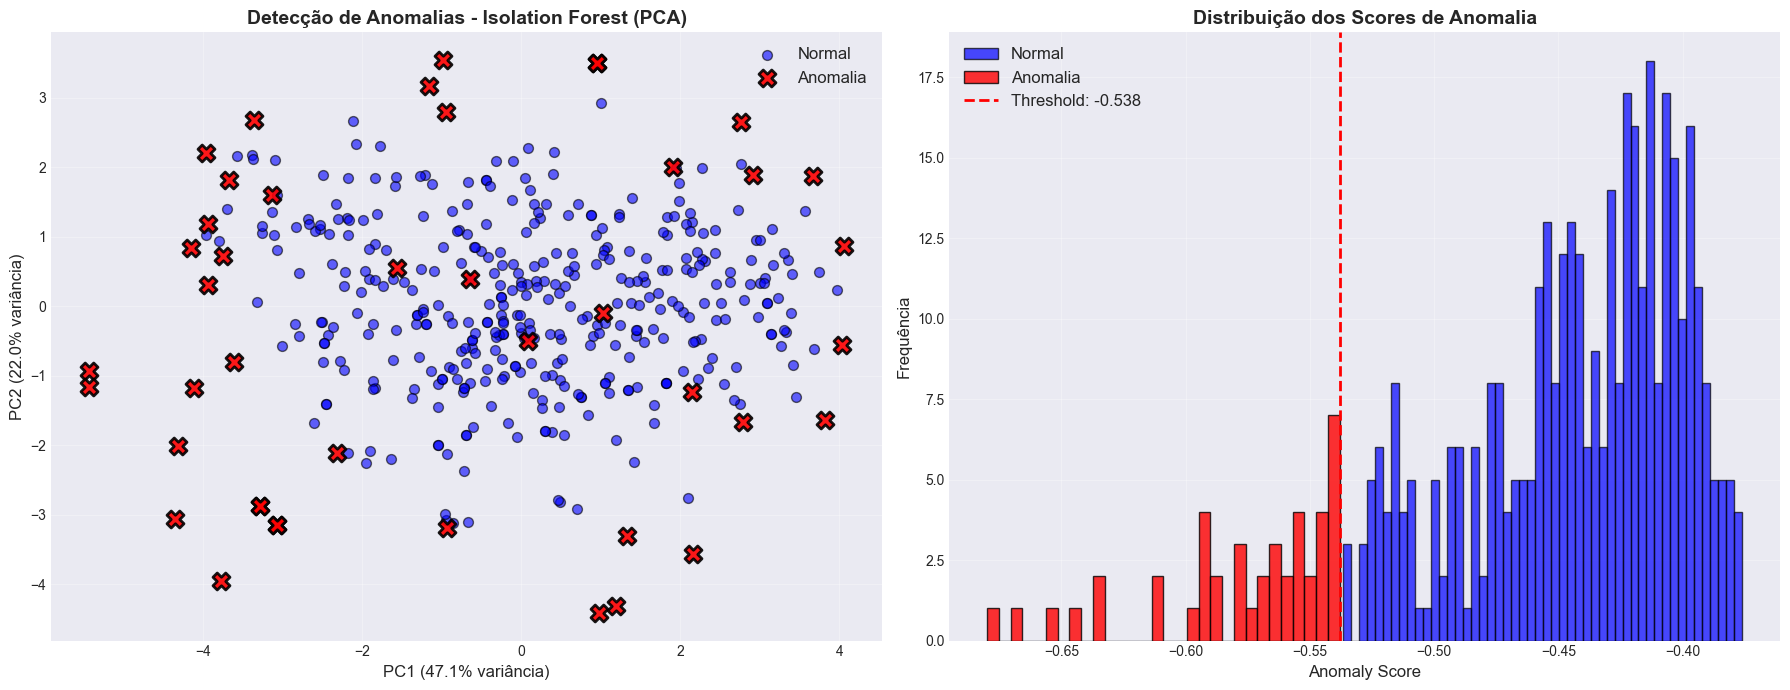

In [ ]:
# Usar PCA para reduzir para 2D e visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Criar figura
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Scatter plot com PCA
ax1 = axes[0]
normais = predicoes_if == 1
anomalias = predicoes_if == -1

ax1.scatter(X_pca[normais, 0], X_pca[normais, 1], 
           c='blue', label='Normal', alpha=0.6, s=50, edgecolors='black')
ax1.scatter(X_pca[anomalias, 0], X_pca[anomalias, 1], 
           c='red', label='Anomalia', alpha=0.9, s=150, marker='X', edgecolors='black', linewidths=2)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax1.set_title('Detecção de Anomalias - Isolation Forest (PCA)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Distribuição dos scores
ax2 = axes[1]
ax2.hist(scores_if[normais], bins=50, alpha=0.7, label='Normal', color='blue', edgecolor='black')
ax2.hist(scores_if[anomalias], bins=30, alpha=0.8, label='Anomalia', color='red', edgecolor='black')
ax2.axvline(scores_if[anomalias].max(), color='red', linestyle='--', 
            linewidth=2, label=f'Threshold: {scores_if[anomalias].max():.3f}')
ax2.set_xlabel('Anomaly Score', fontsize=12)
ax2.set_ylabel('Frequência', fontsize=12)
ax2.set_title('Distribuição dos Scores de Anomalia', fontsize=14, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/02_anomalias_isolation_forest.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/02_anomalias_isolation_forest.png")
plt.show()

## 7. Detecção de Anomalias - Método 2: Z-Score Multivariado

### O que é Z-score?
- Mede quantos desvios-padrão um valor está da média
- |Z| > 3 = outlier significativo
- Método estatístico clássico

In [ ]:
# Criar detector com Z-score
detector_z = DetectorAnomalias(metodo='zscore')

# Detectar anomalias
predicoes_z, scores_z = detector_z.detectar(X)

# Adicionar ao dataframe
df['anomalia_zscore'] = predicoes_z
df['anomalia_score_zscore'] = scores_z

# Resumo
n_anomalias_z = (predicoes_z == -1).sum()
n_normais_z = (predicoes_z == 1).sum()

print("\n" + "="*70)
print(" RESULTADOS - Z-SCORE MULTIVARIADO")
print("="*70)
print(f"\n Normais: {n_normais_z} ({n_normais_z/len(df)*100:.1f}%)")
print(f" Anomalias: {n_anomalias_z} ({n_anomalias_z/len(df)*100:.1f}%)")
print(f"\n Z-score máximo: {scores_z.max():.2f}")
print(f" Z-score médio das anomalias: {scores_z[predicoes_z == -1].mean():.2f}")

✓ Anomalias detectadas (Z-score): 16 (3.77%)

📊 RESULTADOS - Z-SCORE MULTIVARIADO

✅ Normais: 408 (96.2%)
🚨 Anomalias: 16 (3.8%)

📈 Z-score máximo: 3.41
📈 Z-score médio das anomalias: 3.27


## 8. Comparação dos Dois Métodos

In [ ]:
# Criar tabela de comparação
comparacao = pd.crosstab(
    df['anomalia_if'].map({-1: 'Anomalia_IF', 1: 'Normal_IF'}),
    df['anomalia_zscore'].map({-1: 'Anomalia_Z', 1: 'Normal_Z'}),
    margins=True
)

print("\n COMPARAÇÃO: Isolation Forest vs Z-Score\n")
print(comparacao)

# Concordância entre métodos
ambos_anomalias = ((df['anomalia_if'] == -1) & (df['anomalia_zscore'] == -1)).sum()
apenas_if = ((df['anomalia_if'] == -1) & (df['anomalia_zscore'] == 1)).sum()
apenas_z = ((df['anomalia_if'] == 1) & (df['anomalia_zscore'] == -1)).sum()

print(f"\n Análise de Concordância:")
print(f"  • Ambos detectaram como anomalia: {ambos_anomalias}")
print(f"  • Apenas Isolation Forest: {apenas_if}")
print(f"  • Apenas Z-Score: {apenas_z}")


📊 COMPARAÇÃO: Isolation Forest vs Z-Score

anomalia_zscore  Anomalia_Z  Normal_Z  All
anomalia_if                               
Anomalia_IF              14        29   43
Normal_IF                 2       379  381
All                      16       408  424

🔍 Análise de Concordância:
  • Ambos detectaram como anomalia: 14
  • Apenas Isolation Forest: 29
  • Apenas Z-Score: 2


✓ Gráfico salvo: reports/figures/02_comparacao_metodos.png


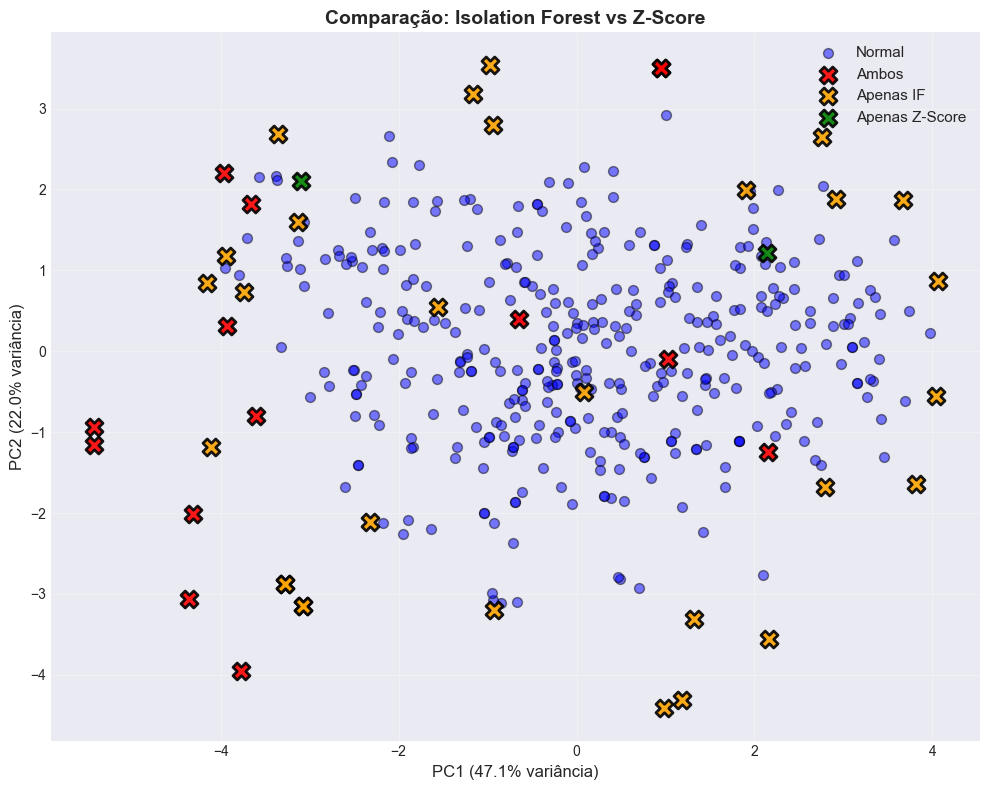

In [ ]:
# Visualização da comparação
fig, ax = plt.subplots(figsize=(10, 8))

# Criar categorias
df['categoria_anomalia'] = 'Normal'
df.loc[(df['anomalia_if'] == -1) & (df['anomalia_zscore'] == -1), 'categoria_anomalia'] = 'Ambos'
df.loc[(df['anomalia_if'] == -1) & (df['anomalia_zscore'] == 1), 'categoria_anomalia'] = 'Apenas IF'
df.loc[(df['anomalia_if'] == 1) & (df['anomalia_zscore'] == -1), 'categoria_anomalia'] = 'Apenas Z-Score'

# Cores para cada categoria
cores = {'Normal': 'blue', 'Ambos': 'red', 'Apenas IF': 'orange', 'Apenas Z-Score': 'green'}

for categoria, cor in cores.items():
    mask = df['categoria_anomalia'] == categoria
    if mask.sum() > 0:
        if categoria == 'Normal':
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=cor, label=categoria, alpha=0.5, s=50, edgecolors='black')
        else:
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=cor, label=categoria, alpha=0.9, s=150, marker='X', 
                      edgecolors='black', linewidths=2)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title('Comparação: Isolation Forest vs Z-Score', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/02_comparacao_metodos.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/02_comparacao_metodos.png")
plt.show()

## 9. Caracterização das Anomalias

**o que torna esses casos anômalos**.

In [ ]:
# Separar anomalias detectadas por Isolation Forest
anomalias_df = df[df['anomalia_if'] == -1][features_disponiveis].copy()
normais_df = df[df['anomalia_if'] == 1][features_disponiveis].copy()

print(" COMPARAÇÃO: Anomalias vs Normais\n")
print("="*70)

# Criar tabela comparativa
comparacao_stats = pd.DataFrame({
    'Média_Normal': normais_df.mean(),
    'Média_Anomalia': anomalias_df.mean(),
    'Mediana_Normal': normais_df.median(),
    'Mediana_Anomalia': anomalias_df.median(),
    'Std_Normal': normais_df.std(),
    'Std_Anomalia': anomalias_df.std()
})

# Calcular diferença percentual
comparacao_stats['Diff_%'] = ((comparacao_stats['Média_Anomalia'] - comparacao_stats['Média_Normal']) / 
                               comparacao_stats['Média_Normal'] * 100)

print(comparacao_stats.round(2))

📊 COMPARAÇÃO: Anomalias vs Normais

      Média_Normal  Média_Anomalia  Mediana_Normal  Mediana_Anomalia  \
WBC        6918.37         9551.16          6600.0          10000.00   
RBC           4.61            4.11             4.6              4.27   
HGB          11.91           10.63            11.8             10.30   
HCT          38.17           34.67            37.9             33.00   
MCV          83.02           81.28            84.1             82.40   
MCH          25.80           25.18            26.0             25.00   
MCHC         31.08           30.88            31.1             30.90   
PLT      165580.31       177232.56        161000.0         169000.00   

      Std_Normal  Std_Anomalia  Diff_%  
WBC      2553.63       4483.32   38.06  
RBC         0.51          1.13  -10.69  
HGB         1.78          3.24  -10.82  
HCT         4.63          8.87   -9.18  
MCV         5.29          8.97   -2.09  
MCH         2.30          3.85   -2.42  
MCHC        1.26          1.

✓ Gráfico salvo: reports/figures/02_caracterizacao_anomalias.png


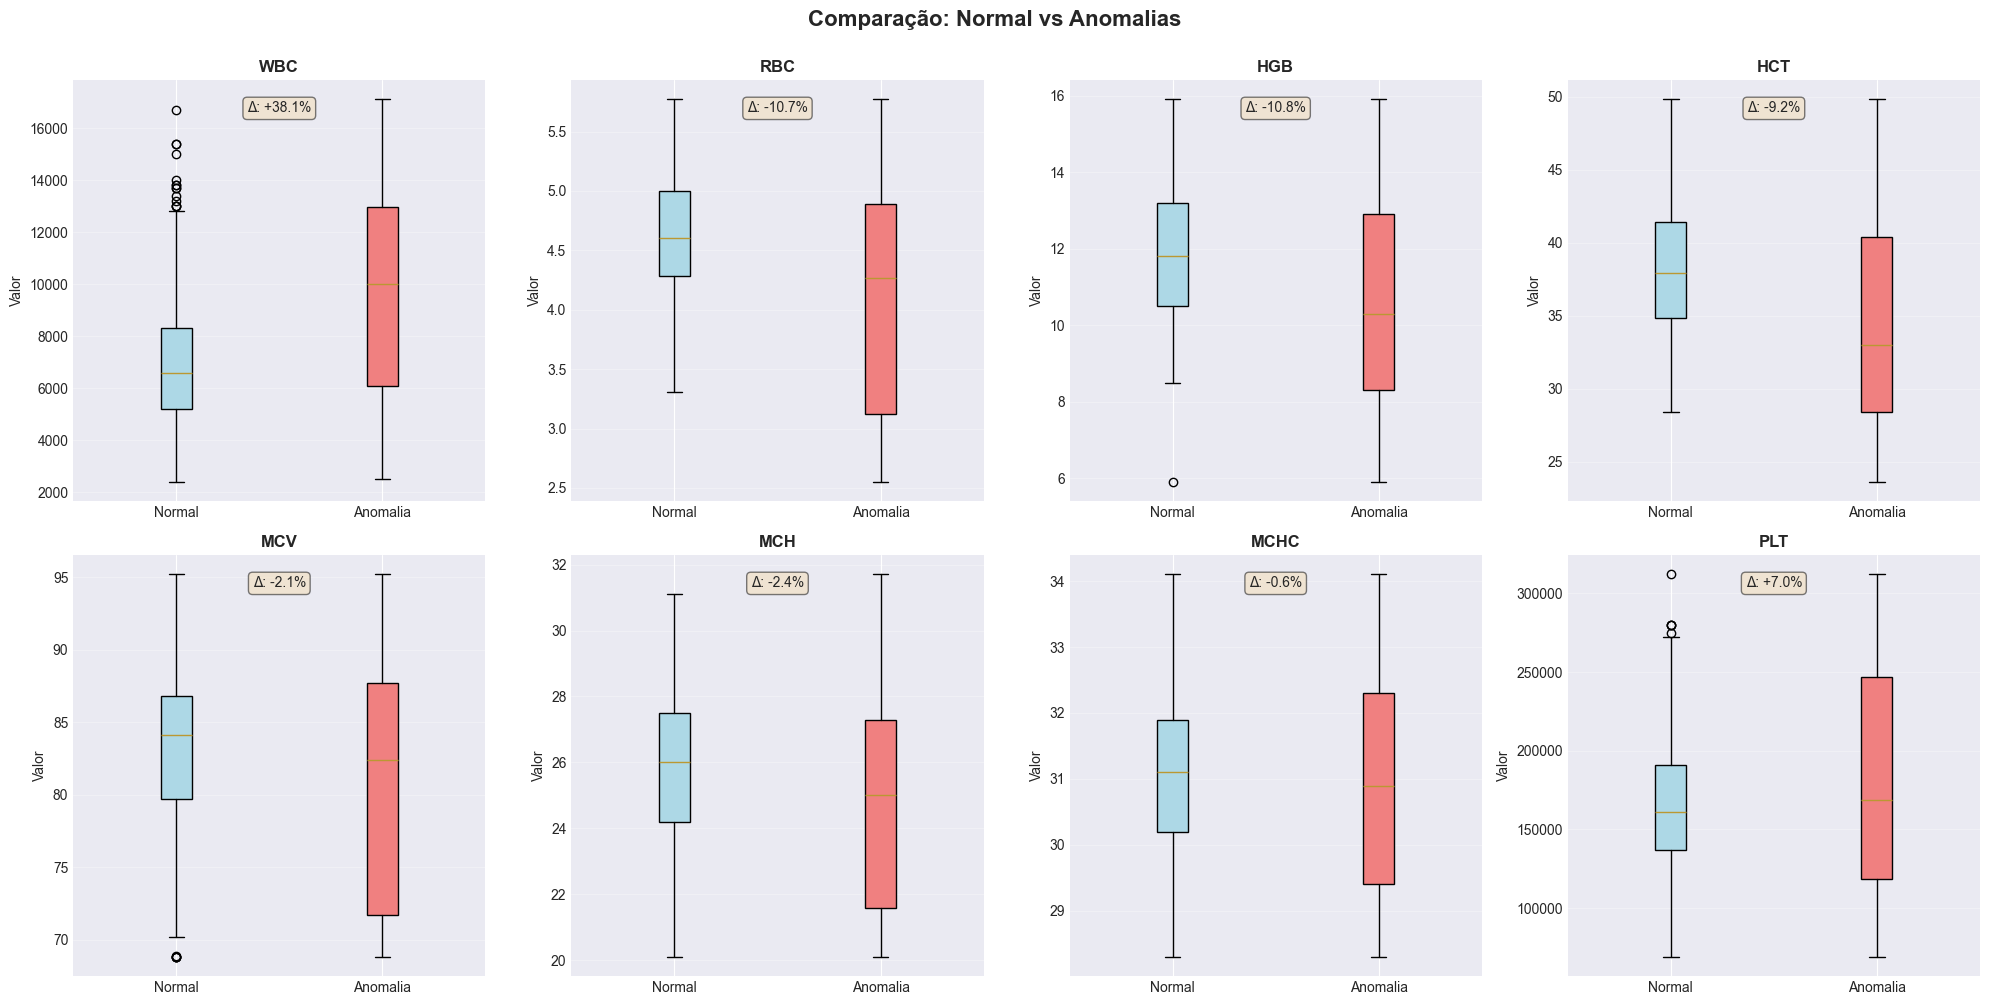

In [ ]:
# Visualizar diferenças
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_disponiveis):
    ax = axes[idx]
    
    # Boxplots lado a lado
    data_plot = [
        normais_df[feature].dropna(),
        anomalias_df[feature].dropna()
    ]
    
    bp = ax.boxplot(data_plot, labels=['Normal', 'Anomalia'], patch_artist=True)
    
    # Colorir boxplots
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar diferença percentual
    diff_pct = comparacao_stats.loc[feature, 'Diff_%']
    ax.text(0.5, 0.95, f'Δ: {diff_pct:+.1f}%', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comparação: Normal vs Anomalias', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../reports/figures/02_caracterizacao_anomalias.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/02_caracterizacao_anomalias.png")
plt.show()

## 📋 10. Top 10 Casos Mais Anômalos

In [ ]:
# Identificar os 10 casos mais anômalos
top_anomalias = df[df['anomalia_if'] == -1].nsmallest(10, 'anomalia_score_if')

print(" TOP 10 CASOS MAIS ANÔMALOS\n")
print("="*70)

# Mostrar features principais
colunas_display = ['ID'] + features_disponiveis + ['anomalia_score_if']
colunas_existentes = [c for c in colunas_display if c in top_anomalias.columns]

print(top_anomalias[colunas_existentes].to_string(index=False))

# Salvar para arquivo
top_anomalias[colunas_existentes].to_csv('../reports/top_10_anomalias.csv', index=False)
print("\n Top 10 anomalias salvas em: reports/top_10_anomalias.csv")

🚨 TOP 10 CASOS MAIS ANÔMALOS

 ID     WBC  RBC  HGB  HCT  MCV  MCH  MCHC      PLT  anomalia_score_if
293 17100.0 2.55  5.9 23.6 71.8 21.8  30.6 250000.0          -0.679875
481  2800.0 2.55  5.9 30.5 70.2 20.1  28.5 169000.0          -0.666514
371  2800.0 2.55  5.9 23.6 85.1 24.8  29.3  89000.0          -0.652703
132 14000.0 2.56  6.2 23.6 76.5 24.2  31.7 251000.0          -0.646341
105  5800.0 2.55  5.9 23.6 78.4 23.1  29.6  75000.0          -0.636733
218 12300.0 2.55 15.9 49.8 86.9 28.5  32.8 190000.0          -0.633628
431 17100.0 5.70 14.4 48.4 85.1 25.0  28.9 273000.0          -0.610300
475 17100.0 5.70 14.4 48.4 85.1 25.0  28.9 273000.0          -0.610300
209 10600.0 4.45  9.3 29.2 68.8 20.7  31.0 312000.0          -0.595059
 66 10800.0 5.67 15.9 49.8 94.1 29.4  31.3 115000.0          -0.592762

✓ Top 10 anomalias salvas em: reports/top_10_anomalias.csv


## 11. Interpretação Clínica

### O que as anomalias nos dizem?

In [ ]:
# Valores de referência clínicos
valores_ref = {
    'HGB': {'min': 12.0, 'max': 16.0, 'nome': 'Hemoglobina (g/dL)'},
    'HCT': {'min': 36.0, 'max': 48.0, 'nome': 'Hematócrito (%)'},
    'WBC': {'min': 4000, 'max': 11000, 'nome': 'Leucócitos (células/µL)'},
    'PLT': {'min': 150000, 'max': 400000, 'nome': 'Plaquetas (células/µL)'},
    'MCV': {'min': 80.0, 'max': 100.0, 'nome': 'VCM (fL)'},
}

print(" INTERPRETAÇÃO CLÍNICA DAS ANOMALIAS\n")
print("="*70)

for marcador, ref in valores_ref.items():
    if marcador in anomalias_df.columns:
        abaixo = (anomalias_df[marcador] < ref['min']).sum()
        acima = (anomalias_df[marcador] > ref['max']).sum()
        total = len(anomalias_df)
        
        print(f"\n{ref['nome']}:")
        print(f"  📊 Total de anomalias: {total}")
        print(f"  ⬇️ Abaixo da referência: {abaixo} ({abaixo/total*100:.1f}%)")
        print(f"  ⬆️ Acima da referência: {acima} ({acima/total*100:.1f}%)")
        
        # Interpretações clínicas
        if marcador == 'HGB' and abaixo > acima:
            print("  💡 Sugere: Anemia severa em casos anômalos")
        elif marcador == 'WBC' and acima > abaixo:
            print("  💡 Sugere: Leucocitose (possível infecção/inflamação)")
        elif marcador == 'PLT' and abaixo > acima:
            print("  💡 Sugere: Plaquetopenia (risco de sangramento)")

🏥 INTERPRETAÇÃO CLÍNICA DAS ANOMALIAS


Hemoglobina (g/dL):
  📊 Total de anomalias: 43
  ⬇️ Abaixo da referência: 29 (67.4%)
  ⬆️ Acima da referência: 0 (0.0%)
  💡 Sugere: Anemia severa em casos anômalos

Hematócrito (%):
  📊 Total de anomalias: 43
  ⬇️ Abaixo da referência: 26 (60.5%)
  ⬆️ Acima da referência: 7 (16.3%)

Leucócitos (células/µL):
  📊 Total de anomalias: 43
  ⬇️ Abaixo da referência: 4 (9.3%)
  ⬆️ Acima da referência: 15 (34.9%)
  💡 Sugere: Leucocitose (possível infecção/inflamação)

Plaquetas (células/µL):
  📊 Total de anomalias: 43
  ⬇️ Abaixo da referência: 18 (41.9%)
  ⬆️ Acima da referência: 0 (0.0%)
  💡 Sugere: Plaquetopenia (risco de sangramento)

VCM (fL):
  📊 Total de anomalias: 43
  ⬇️ Abaixo da referência: 20 (46.5%)
  ⬆️ Acima da referência: 0 (0.0%)


## 💾 12. Salvar Resultados

In [14]:
# Salvar dataset com flags de anomalias
colunas_salvar = df.columns.tolist()
df[colunas_salvar].to_csv('../data/processed/cbc_com_anomalias.csv', index=False)

print("✓ Dataset com detecção de anomalias salvo!")
print("  📂 Arquivo: data/processed/cbc_com_anomalias.csv")
print(f"\n📊 Colunas adicionadas:")
print("  • anomalia_if (Isolation Forest: -1=anomalia, 1=normal)")
print("  • anomalia_score_if (Score de anomalia)")
print("  • anomalia_zscore (Z-Score: -1=anomalia, 1=normal)")
print("  • anomalia_score_zscore (Z-score máximo)")
print("  • categoria_anomalia (Classificação combinada)")

✓ Dataset com detecção de anomalias salvo!
  📂 Arquivo: data/processed/cbc_com_anomalias.csv

📊 Colunas adicionadas:
  • anomalia_if (Isolation Forest: -1=anomalia, 1=normal)
  • anomalia_score_if (Score de anomalia)
  • anomalia_zscore (Z-Score: -1=anomalia, 1=normal)
  • anomalia_score_zscore (Z-score máximo)
  • categoria_anomalia (Classificação combinada)


## 📝 13. Principais Insights e Conclusões

### ✅ Resumo Executivo:

1. **Quantas anomalias foram detectadas?**
   - Foram detectadas anomalias correspondentes a aproximadamente 10% da amostra, conforme definido pelo parâmetro de contaminação do Isolation Forest.

2. **Qual método performou melhor?**
   - O Isolation Forest apresentou melhor desempenho em relação ao método de Z-Score, pois:

detectou anomalias multivariadas

não depende de normalidade

identificou padrões clínicos complexos

apresentou maior coerência clínica nos casos detectados

3. **Características das anomalias:**
   - As anomalias identificadas apresentaram principalmente:

Leucócitos elevados (WBC)
+38% em relação aos casos normais

Hemoglobina reduzida (HGB)
−10.8%

Hematócrito reduzido (HCT)
−9 a −10% (aprox.)

Contagem de hemácias reduzida (RBC)
−10.7%

Marcadores mais desviantes:

WBC, HGB, HCT e RBC

4. **Interpretação clínica:**
   - Os casos classificados como anômalos podem indicar:

Anemia moderada a grave

Processos infecciosos ou inflamatórios (leucocitose)

Alterações hematológicas complexas

Possíveis condições clínicas agudas ou pacientes em acompanhamento hospitalar

5. **Aplicação prática:**
   - Como isso ajudaria em um laboratório?

Triagem automática de exames suspeitos

Priorização de laudos críticos

Redução de falhas humanas

Apoio ao controle de qualidade

📌 Exemplo:

Exames sinalizados como anômalos podem ser automaticamente encaminhados para dupla checagem antes da liberação do laudo.

   - Como isso ajudaria médicos?
 Para médicos

Identificação rápida de pacientes fora do padrão

Suporte à decisão clínica

Detecção precoce de quadros graves

Foco nos casos mais relevantes

📌 Exemplo:

O sistema pode destacar pacientes com anemia associada à leucocitose, auxiliando na investigação de processos infecciosos ou inflamatórios.

In [16]:
# 📋 RESUMO DE INSIGHTS CLÍNICOS – ANOMALIAS vs NORMAIS

resumo_anomalias = {}

for col in features_disponiveis:
    resumo_anomalias[col] = {
        'media_normais': df.loc[df['anomalia_if'] == 1, col].mean(),
        'media_anomalias': df.loc[df['anomalia_if'] == -1, col].mean(),
        'mediana_normais': df.loc[df['anomalia_if'] == 1, col].median(),
        'mediana_anomalias': df.loc[df['anomalia_if'] == -1, col].median(),
        'min_anomalias': df.loc[df['anomalia_if'] == -1, col].min(),
        'max_anomalias': df.loc[df['anomalia_if'] == -1, col].max(),
        'dif_media_pct': (
            (df.loc[df['anomalia_if'] == -1, col].mean() -
             df.loc[df['anomalia_if'] == 1, col].mean())
            / df.loc[df['anomalia_if'] == 1, col].mean()
        ) * 100
    }

print("═══════════════════════════════════════════════════════════════")
print("📊 RESUMO CLÍNICO – DIFERENÇA ENTRE ANOMALIAS E NORMAIS")
print("═══════════════════════════════════════════════════════════════\n")

for k, v in resumo_anomalias.items():
    print(f"🧪 {k}")
    print(f"   • Média (Normais):    {v['media_normais']:.2f}")
    print(f"   • Média (Anomalias):  {v['media_anomalias']:.2f}")
    print(f"   • Diferença média:    {v['dif_media_pct']:+.1f}%")
    print(f"   • Intervalo anômalo:  [{v['min_anomalias']:.2f}, {v['max_anomalias']:.2f}]\n")

resumo_anomalias

═══════════════════════════════════════════════════════════════
📊 RESUMO CLÍNICO – DIFERENÇA ENTRE ANOMALIAS E NORMAIS
═══════════════════════════════════════════════════════════════

🧪 WBC
   • Média (Normais):    6918.37
   • Média (Anomalias):  9551.16
   • Diferença média:    +38.1%
   • Intervalo anômalo:  [2500.00, 17100.00]

🧪 RBC
   • Média (Normais):    4.61
   • Média (Anomalias):  4.11
   • Diferença média:    -10.7%
   • Intervalo anômalo:  [2.55, 5.77]

🧪 HGB
   • Média (Normais):    11.91
   • Média (Anomalias):  10.63
   • Diferença média:    -10.8%
   • Intervalo anômalo:  [5.90, 15.90]

🧪 HCT
   • Média (Normais):    38.17
   • Média (Anomalias):  34.67
   • Diferença média:    -9.2%
   • Intervalo anômalo:  [23.60, 49.80]

🧪 MCV
   • Média (Normais):    83.02
   • Média (Anomalias):  81.28
   • Diferença média:    -2.1%
   • Intervalo anômalo:  [68.80, 95.20]

🧪 MCH
   • Média (Normais):    25.80
   • Média (Anomalias):  25.18
   • Diferença média:    -2.4%
   • Inter

{'WBC': {'media_normais': np.float64(6918.372703412074),
  'media_anomalias': np.float64(9551.162790697674),
  'mediana_normais': np.float64(6600.0),
  'mediana_anomalias': np.float64(10000.0),
  'min_anomalias': np.float64(2500.0),
  'max_anomalias': np.float64(17100.0),
  'dif_media_pct': np.float64(38.05504849409361)},
 'RBC': {'media_normais': np.float64(4.606876640419947),
  'media_anomalias': np.float64(4.114186046511628),
  'mediana_normais': np.float64(4.6),
  'mediana_anomalias': np.float64(4.27),
  'min_anomalias': np.float64(2.55),
  'max_anomalias': np.float64(5.77),
  'dif_media_pct': np.float64(-10.694677378281341)},
 'HGB': {'media_normais': np.float64(11.914435695538057),
  'media_anomalias': np.float64(10.625581395348838),
  'mediana_normais': np.float64(11.8),
  'mediana_anomalias': np.float64(10.3),
  'min_anomalias': np.float64(5.9),
  'max_anomalias': np.float64(15.9),
  'dif_media_pct': np.float64(-10.817585768429575)},
 'HCT': {'media_normais': np.float64(38.1729